# Fraud Detection Demo

Based on: https://www.kaggle.com/code/zwhjorth/dnn-svm-and-dt-for-fraud-detection


In [6]:
# Install all requirements needed to train and save this model.

!pip install pip numpy pandas tensorflow matplotlib seaborn tf2onnx onnxruntime scikit-learn boto3 -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [7]:
# Import the dependencies we need to run the code.

import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns
import tf2onnx
from sklearn.linear_model import LogisticRegression

### Load and process the data

In [8]:
# Load the CSV data which we will use to train the model.
# It contains the following fields:
#   distancefromhome - The distance from home where the transaction happened.
#   distancefromlast_transaction - The distance from last transaction happened.
#   ratiotomedianpurchaseprice - Ratio of purchased price compared to median purchase price.
#   repeat_retailer - If it's from a retailer that already has been purchased from before.
#   used_chip - If the (credit card) chip was used.
#   usedpinnumber - If the PIN number was used.
#   online_order - If it was an online order.
#   fraud - If the transaction is fraudulent.

Data = pd.read_csv('../data/card_transdata.csv')
Data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [9]:
# Set the input (X) and output (Y) data. 
# The only output data we have is if it's fraudulent or not, and all other fields go as inputs to the model.

X = Data.drop(columns = ['fraud'])
y = Data['fraud']

# Split the data into training and testing sets so we have something to test the trained model with.

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# Scale the data to remove mean and have unit variance. This means that the data will be between -1 and 1, which makes it a lot easier for the model to learn than random potentially large values.
# It is important to only fit the scaler to the training data, otherwise you are leaking information about the global distribution of variables (which is influenced by the test set) into the training set.

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

# Since the dataset is unbalanced (it has many more non-fraud transactions than fraudulent ones), we set a class weight to weight the few fraudulent transactions higher than the many non-fraud transactions.

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

### Build the model.

In [10]:
# Build the model, the model we build here is a simple fully connected deep neural network, containing 3 hidden layers and one output layer.
#
# Name the input layer for model metadata consistency.
#
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=len(X.columns), name="dense"))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                256       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                      

### Model Training and scoring

Epoch 1/2
20000/20000 [==============================] - 83s 4ms/step - loss: 0.0933 - accuracy: 0.9600 - val_loss: 0.0748 - val_accuracy: 0.9684
Epoch 2/2
6250/6250 [==============================] - 10s 2ms/step


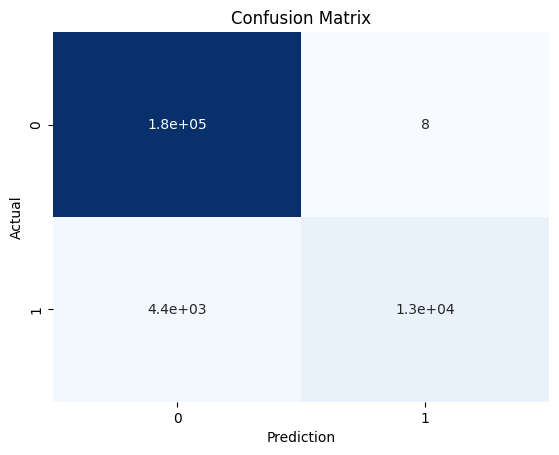

true -: 182511
false +: 8
false -: 4425
true +: 13056


2023-05-09 14:49:46.948405: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-09 14:49:46.948852: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-05-09 14:49:47.455926: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-09 14:49:47.456966: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [11]:
epochs = 2
history = model.fit(X_train, y_train, epochs=epochs, \
                    validation_data=(scaler.transform(X_val),y_val), \
                    verbose = True, class_weight = class_weights)

y_pred_temp = model.predict(scaler.transform(X_test)) 

threshold = 0.995

y_pred = np.where(y_pred_temp > threshold, 1,0)
c_matrix = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

t_n, f_p, f_n, t_p = c_matrix.ravel()
print(f"true -: {t_n}")
print(f"false +: {f_p}")
print(f"false -: {f_n}")
print(f"true +: {t_p}")

model_proto,_ = tf2onnx.convert.from_keras(model)

### Save the model in onnx format and upload to S3 object storage.

In [12]:
#
# Simple boto3 client function to upload a file to an S3 compatible object store.
#

import boto3
import botocore.exceptions
import os

def upload_file(s3_client, file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param s3_client: The client connection handle. 
    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used 
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = os.path.basename(file_name)
    try:    
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [13]:
import onnx
model_filename = 'fraud.onnx'
onnx.save(model_proto, model_filename)

In [14]:
#
# Authenticate with the S3 service.
#
client = boto3.client(
    's3',   
    aws_access_key_id=os.getenv("FUSION_ACCESS_KEY"),
    aws_secret_access_key=os.getenv("FUSION_SECRET_KEY"),
    endpoint_url=os.getenv("FUSION_S3_ENDPOINT")
)

# print()
# print("List buckets:")
# print(client.list_buckets())
# print()

print("Uploading file to S3...") 

upload_file(client, model_filename, os.getenv("FUSION_VAULT"))

Uploading file to S3...


True